In [24]:
!pip install pandas
!pip install lightning
!pip install pytorch-lightning
!pip install matplotlib
!pip install torchvision


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [25]:
import ssl
import torch
import torchmetrics
import numpy as np
import pandas as pd
from torch import nn
import lightning as L
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import Imagenette, CIFAR10
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

In [26]:
class BaseCNN(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes

        self.train_epoch_losses = []
        self.val_epoch_losses = []

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

        # For accumulating loss in an epoch
        self._train_epoch_loss = 0.0
        self._val_epoch_loss = 0.0
        self._train_batches = 0
        self._val_batches = 0

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        self._train_epoch_loss += loss.item()
        self._train_batches += 1

        self.log("train_loss_step", loss)
        return loss

    def on_train_epoch_end(self):
        avg_loss = self._train_epoch_loss / self._train_batches if self._train_batches > 0 else 0
        self.train_epoch_losses.append(avg_loss)
        self.log("train_loss", avg_loss)
        print(f"Epoch {self.current_epoch}: Avg Train Loss = {avg_loss:.4f}")

        self._train_epoch_loss = 0.0
        self._train_batches = 0

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        self._val_epoch_loss += loss.item()
        self._val_batches += 1

        self.accuracy(y_hat, y)

        self.log("val_loss_step", loss)
        self.log("val_accuracy", self.accuracy)
        return loss

    def on_validation_epoch_end(self):
        avg_loss = self._val_epoch_loss / self._val_batches if self._val_batches > 0 else 0
        self.val_epoch_losses.append(avg_loss)
        self.log("val_loss", avg_loss)
        print(f"Epoch {self.current_epoch}: Avg Validation Loss = {avg_loss:.4f}")

        self._val_epoch_loss = 0.0
        self._val_batches = 0

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        self.accuracy(y_hat, y)
        self.log("test_loss", loss)
        self.log("test_accuracy", self.accuracy)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4, weight_decay=1e-4)

🔹 1. BasicCNN
Architecture Overview:
A simple Convolutional Neural Network designed for image classification on grayscale images (1-channel). It consists of three convolutional blocks followed by two fully connected layers.

Layers:
- Input Channels: 1 (grayscale image)

Convolutional Layers:

- Conv2d(1, 32, kernel_size=3, padding=1) → ReLU → MaxPool2d(2)

- Conv2d(32, 64, kernel_size=3, padding=1) → ReLU → MaxPool2d(2)

- Conv2d(64, 128, kernel_size=3, padding=1) → ReLU → MaxPool2d(2)

Flattening: Input is reshaped into a vector of size 128 * 8 * 8 (assuming 64x64 input size).

Fully Connected Layers:

- Linear(128 * 8 * 8, 256) → ReLU

- Linear(256, num_classes)

In [27]:
class BasicCNN(BaseCNN):
    def __init__(self, num_classes=10):
        super().__init__(num_classes)

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)

🔹 2. PretrainedResNet18
Architecture Overview:
This model uses a pretrained ResNet18 backbone from torchvision, modified to accept grayscale images and output predictions for the target number of classes. The rest of the ResNet structure remains intact.

Key Modifications:
- First Convolutional Layer Modified: Replaced Conv2d(3, 64, ...) with Conv2d(1, 64, ...) to support grayscale inputs.

- Final Fully Connected Layer: Replaced with Linear(in_features, num_classes) to match the number of target classes.

- Optional Freezing: Can freeze all layers except the final FC layer for transfer learning.

In [28]:
class PretrainedResNet18(BaseCNN):
    def __init__(self, num_classes=10, freeze_backbone=False):
        super().__init__()

        # Load pretrained model
        self.model = models.resnet18(pretrained=True)

        # Convert first conv layer if using grayscale (1-channel) input
        if self.model.conv1.in_channels != 1:
            self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace final layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

        # Optionally freeze feature extractor
        if freeze_backbone:
            for param in self.model.parameters():
                param.requires_grad = False
            # Unfreeze the final layer
            for param in self.model.fc.parameters():
                param.requires_grad = True

        self.train_losses = []
        self.val_losses = []
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

🔹 3. RegularizationCNN
Architecture Overview:
This architecture is identical to BasicCNN, with Dropout regularization added after the first fully connected layer to prevent overfitting.

Additional Regularization:
- Dropout(0.5) added between the two FC layers.

In [29]:
class RegularizationCNN(BaseCNN):
    def __init__(self, num_classes=10):
        super().__init__(num_classes)

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout added here
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)


In [30]:
def plot_losses(model):
    plt.figure(figsize=(10, 5))
    plt.plot(model.train_epoch_losses, label="Training Loss")
    plt.plot(model.val_epoch_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss per Epoch")
    plt.legend()
    plt.show()

# --- Callbacks ---
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    dirpath="./checkpoints",
    filename="model_weights",
    save_top_k=1,
    verbose=True
)


# Basic CNN

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | accuracy    | MulticlassAccuracy | 0      | train
1 | conv_layers | Sequential         | 92.7 K | train
2 | fc_layers   | Sequential         | 2.1 M  | train
-----------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.771     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 67/67 [00:03<00:00, 21.32it/s, v_num=21]         
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 51.99it/s] Epoch 0: Avg Validation Loss = 1.9230

Epoch 0: 100%|██████████| 67/67 [00:03<00:00, 19.83it/s, v_num=21]    

Epoch 0, global step 67: 'val_loss' reached 1.92297 (best 1.92297), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/model_weights-v2.ckpt' as top 1


Epoch 0: Avg Train Loss = 2.0982
Epoch 1: 100%|██████████| 67/67 [00:01<00:00, 34.35it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 99.23it/s]Epoch 1: Avg Validation Loss = 1.7378

Epoch 1: 100%|██████████| 67/67 [00:02<00:00, 30.69it/s, v_num=21]    

Epoch 1, global step 134: 'val_loss' reached 1.73783 (best 1.73783), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/model_weights-v2.ckpt' as top 1


Epoch 1: Avg Train Loss = 1.8183
Epoch 2: 100%|██████████| 67/67 [00:01<00:00, 34.81it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 122.94it/s]Epoch 2: Avg Validation Loss = 1.6558

Epoch 2: 100%|██████████| 67/67 [00:02<00:00, 32.82it/s, v_num=21]     

Epoch 2, global step 201: 'val_loss' reached 1.65577 (best 1.65577), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/model_weights-v2.ckpt' as top 1


Epoch 2: Avg Train Loss = 1.6756
Epoch 3: 100%|██████████| 67/67 [00:01<00:00, 33.67it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 101.46it/s]Epoch 3: Avg Validation Loss = 1.5666

Epoch 3: 100%|██████████| 67/67 [00:02<00:00, 31.57it/s, v_num=21]     

Epoch 3, global step 268: 'val_loss' reached 1.56664 (best 1.56664), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/model_weights-v2.ckpt' as top 1


Epoch 3: Avg Train Loss = 1.5899
Epoch 4: 100%|██████████| 67/67 [00:02<00:00, 29.29it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 65.12it/s]Epoch 4: Avg Validation Loss = 1.4999

Epoch 4: 100%|██████████| 67/67 [00:02<00:00, 26.94it/s, v_num=21]    Epoch 4: Avg Train Loss = 1.5097


Epoch 4, global step 335: 'val_loss' reached 1.49990 (best 1.49990), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/model_weights-v2.ckpt' as top 1


Epoch 5: 100%|██████████| 67/67 [00:01<00:00, 34.48it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 110.27it/s]Epoch 5: Avg Validation Loss = 1.4567

Epoch 5: 100%|██████████| 67/67 [00:02<00:00, 32.41it/s, v_num=21]     Epoch 5: Avg Train Loss = 1.4525


Epoch 5, global step 402: 'val_loss' reached 1.45669 (best 1.45669), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/model_weights-v2.ckpt' as top 1


Epoch 6: 100%|██████████| 67/67 [00:01<00:00, 34.81it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 121.72it/s]Epoch 6: Avg Validation Loss = 1.4661

Epoch 6: 100%|██████████| 67/67 [00:02<00:00, 32.80it/s, v_num=21]     

Epoch 6, global step 469: 'val_loss' was not in top 1


Epoch 6: Avg Train Loss = 1.4035
Epoch 7: 100%|██████████| 67/67 [00:01<00:00, 34.53it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 119.93it/s]Epoch 7: Avg Validation Loss = 1.4053

Epoch 7: 100%|██████████| 67/67 [00:02<00:00, 32.53it/s, v_num=21]     

Epoch 7, global step 536: 'val_loss' reached 1.40532 (best 1.40532), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/model_weights-v2.ckpt' as top 1


Epoch 7: Avg Train Loss = 1.3552
Epoch 8: 100%|██████████| 67/67 [00:01<00:00, 35.05it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 114.26it/s]Epoch 8: Avg Validation Loss = 1.3859

Epoch 8: 100%|██████████| 67/67 [00:02<00:00, 32.93it/s, v_num=21]     

Epoch 8, global step 603: 'val_loss' reached 1.38589 (best 1.38589), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/model_weights-v2.ckpt' as top 1


Epoch 8: Avg Train Loss = 1.3161
Epoch 9: 100%|██████████| 67/67 [00:01<00:00, 34.54it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 127.85it/s]Epoch 9: Avg Validation Loss = 1.3466

Epoch 9: 100%|██████████| 67/67 [00:02<00:00, 32.63it/s, v_num=21]     

Epoch 9, global step 670: 'val_loss' reached 1.34657 (best 1.34657), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/model_weights-v2.ckpt' as top 1


Epoch 9: Avg Train Loss = 1.2887
Epoch 10: 100%|██████████| 67/67 [00:01<00:00, 33.77it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 111.21it/s]Epoch 10: Avg Validation Loss = 1.3709

Epoch 10: 100%|██████████| 67/67 [00:02<00:00, 31.79it/s, v_num=21]    

Epoch 10, global step 737: 'val_loss' was not in top 1


Epoch 10: Avg Train Loss = 1.2506
Epoch 11: 100%|██████████| 67/67 [00:01<00:00, 34.83it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 111.07it/s]Epoch 11: Avg Validation Loss = 1.3102

Epoch 11: 100%|██████████| 67/67 [00:02<00:00, 32.75it/s, v_num=21]    

Epoch 11, global step 804: 'val_loss' reached 1.31021 (best 1.31021), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/model_weights-v2.ckpt' as top 1


Epoch 11: Avg Train Loss = 1.2123
Epoch 12: 100%|██████████| 67/67 [00:01<00:00, 34.65it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 98.19it/s]Epoch 12: Avg Validation Loss = 1.3429

Epoch 12: 100%|██████████| 67/67 [00:02<00:00, 32.41it/s, v_num=21]   

Epoch 12, global step 871: 'val_loss' was not in top 1


Epoch 12: Avg Train Loss = 1.1817
Epoch 13: 100%|██████████| 67/67 [00:01<00:00, 35.05it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 119.27it/s]Epoch 13: Avg Validation Loss = 1.3283

Epoch 13: 100%|██████████| 67/67 [00:02<00:00, 32.98it/s, v_num=21]    

Epoch 13, global step 938: 'val_loss' was not in top 1


Epoch 13: Avg Train Loss = 1.1622
Epoch 14: 100%|██████████| 67/67 [00:01<00:00, 33.85it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 104.49it/s]Epoch 14: Avg Validation Loss = 1.3105

Epoch 14: 100%|██████████| 67/67 [00:02<00:00, 31.67it/s, v_num=21]    

Epoch 14, global step 1005: 'val_loss' was not in top 1


Epoch 14: Avg Train Loss = 1.1072
Epoch 15: 100%|██████████| 67/67 [00:02<00:00, 32.17it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 95.48it/s]Epoch 15: Avg Validation Loss = 1.2603

Epoch 15: 100%|██████████| 67/67 [00:02<00:00, 29.13it/s, v_num=21]   

Epoch 15, global step 1072: 'val_loss' reached 1.26028 (best 1.26028), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/model_weights-v2.ckpt' as top 1


Epoch 15: Avg Train Loss = 1.0685
Epoch 16: 100%|██████████| 67/67 [00:01<00:00, 34.40it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 104.62it/s]Epoch 16: Avg Validation Loss = 1.3119

Epoch 16: 100%|██████████| 67/67 [00:02<00:00, 30.53it/s, v_num=21]    

Epoch 16, global step 1139: 'val_loss' was not in top 1


Epoch 16: Avg Train Loss = 1.0451
Epoch 17: 100%|██████████| 67/67 [00:01<00:00, 36.26it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 59.01it/s]Epoch 17: Avg Validation Loss = 1.2322

Epoch 17: 100%|██████████| 67/67 [00:02<00:00, 31.88it/s, v_num=21]   

Epoch 17, global step 1206: 'val_loss' reached 1.23222 (best 1.23222), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/model_weights-v2.ckpt' as top 1


Epoch 17: Avg Train Loss = 1.0080
Epoch 18: 100%|██████████| 67/67 [00:02<00:00, 30.41it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 94.76it/s]Epoch 18: Avg Validation Loss = 1.2563

Epoch 18: 100%|██████████| 67/67 [00:02<00:00, 27.53it/s, v_num=21]   

Epoch 18, global step 1273: 'val_loss' was not in top 1


Epoch 18: Avg Train Loss = 0.9850
Epoch 19: 100%|██████████| 67/67 [00:01<00:00, 35.37it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 99.78it/s]Epoch 19: Avg Validation Loss = 1.2647

Epoch 19: 100%|██████████| 67/67 [00:02<00:00, 32.80it/s, v_num=21]   

Epoch 19, global step 1340: 'val_loss' was not in top 1


Epoch 19: Avg Train Loss = 0.9496
Epoch 20: 100%|██████████| 67/67 [00:01<00:00, 33.91it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 128.33it/s]Epoch 20: Avg Validation Loss = 1.2378

Epoch 20: 100%|██████████| 67/67 [00:02<00:00, 32.02it/s, v_num=21]    

Epoch 20, global step 1407: 'val_loss' was not in top 1


Epoch 20: Avg Train Loss = 0.9267
Epoch 21: 100%|██████████| 67/67 [00:02<00:00, 31.03it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 125.33it/s]Epoch 21: Avg Validation Loss = 1.2576

Epoch 21: 100%|██████████| 67/67 [00:02<00:00, 29.46it/s, v_num=21]    

Epoch 21, global step 1474: 'val_loss' was not in top 1


Epoch 21: Avg Train Loss = 0.8856
Epoch 22: 100%|██████████| 67/67 [00:01<00:00, 34.15it/s, v_num=21]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 129.19it/s]Epoch 22: Avg Validation Loss = 1.2778

Epoch 22: 100%|██████████| 67/67 [00:02<00:00, 32.27it/s, v_num=21]    

Epoch 22, global step 1541: 'val_loss' was not in top 1


Epoch 22: Avg Train Loss = 0.8532
Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 35.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.5910828113555908
        test_loss           1.3126211166381836
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


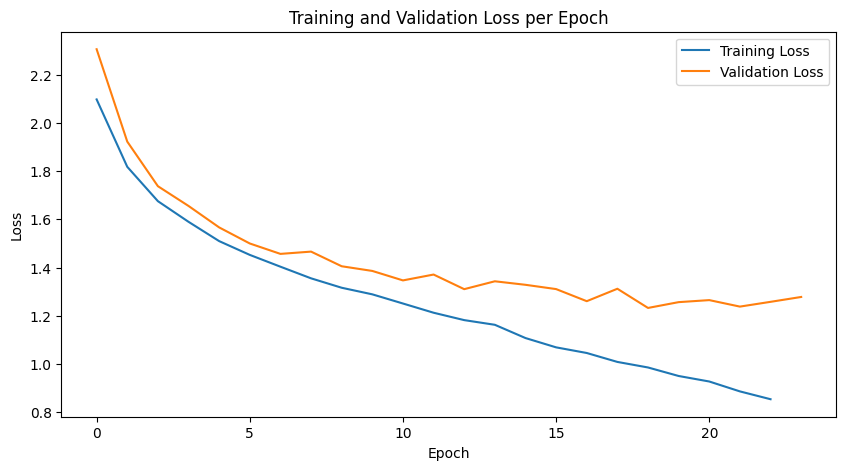

In [31]:
# --- BasicCNN Data Transforms ---
basic_cnn_train_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    transforms.Grayscale()
])

basic_cnn_test_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    transforms.Grayscale()
])

# --- Load Imagenette Dataset ---
train_dataset = Imagenette("data/imagenette/train/", split="train", size="160px", download=True, transform=basic_cnn_train_transforms)
test_dataset = Imagenette("data/imagenette/test/", split="val", size="160px", download=True, transform=basic_cnn_test_transforms)

# --- Split into training and validation ---
train_set_size = int(len(train_dataset) * 0.9)
val_set_size = len(train_dataset) - train_set_size

seed = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(train_dataset, [train_set_size, val_set_size], generator=seed)
val_dataset.dataset.transform = basic_cnn_test_transforms

train_loader = DataLoader(train_dataset, batch_size=128, num_workers=8, shuffle=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=8, shuffle=False, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=256, num_workers=8, shuffle=False, persistent_workers=True)

# --- Select model: BasicCNN or RegularizationCNN ---
basic_cnn_model = BasicCNN(num_classes=10)
# model = RegularizationCNN(num_classes=10)

# --- Trainer ---
basic_cnn_trainer = L.Trainer(callbacks=[early_stop_callback, checkpoint_callback], max_epochs=50)
basic_cnn_trainer.fit(model=basic_cnn_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# --- Test ---
basic_cnn_trainer.test(model=basic_cnn_model, dataloaders=test_loader)

plot_losses(basic_cnn_model)

#  ResNet18 Pretrained

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0      | train
1 | model    | ResNet             | 11.2 M | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 67/67 [00:05<00:00, 11.32it/s, v_num=22]         
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 42.71it/s]Epoch 0: Avg Validation Loss = 1.3420

Epoch 1: 100%|██████████| 67/67 [00:05<00:00, 12.13it/s, v_num=22]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 44.50it/s]Epoch 1: Avg Validation Loss = 1.2286

Epoch 2: 100%|██████████| 67/67 [00:05<00:00, 12.88it/s, v_num=22]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 56.42it/s]Epoch 2: Avg Validation Loss = 1.2710

Epoch 3: 100%|██████████| 67/67 [00:06<00:00,  9.83it/s, v_num=22]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 56.66it/s]Epoch 3: Avg Validation Loss = 1.3422

Epoch 4: 100%|██████████| 67/67 [00:06<00:00, 11.10it/s, v_num=22]
Validation: |          | 0/? [00:00<

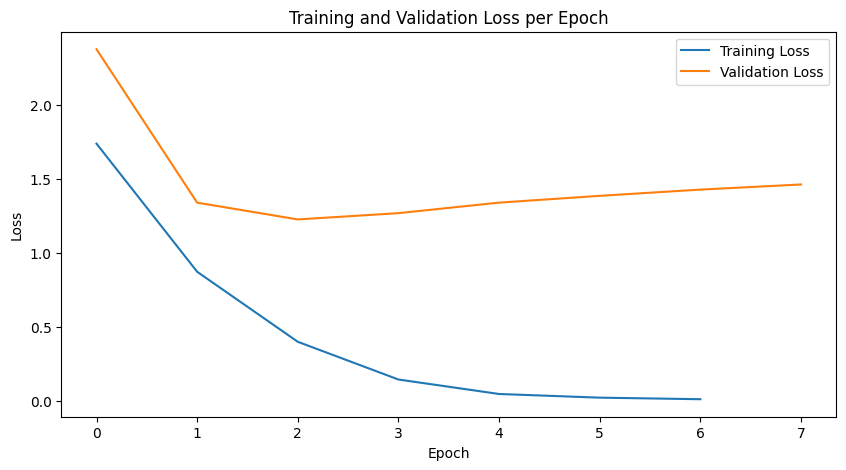

In [32]:
# Prepare the dataset
train_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    transforms.Grayscale()
])

test_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    transforms.Grayscale()
])

train_dataset = Imagenette("data/imagenette/train/", split="train", size="160px", download=False,
                           transform=train_transforms)

train_set_size = int(len(train_dataset) * 0.9)
val_set_size = len(train_dataset) - train_set_size

seed = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_set_size, val_set_size],
                                                           generator=seed)
val_dataset.dataset.transform = test_transforms

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, num_workers=8, shuffle=True, persistent_workers=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, num_workers=8, shuffle=False, persistent_workers=True)

test_dataset = Imagenette("data/imagenette/test/", split="val", size="160px", download=False, transform=test_transforms)

# 🔁 Use pretrained ResNet18, assuming 10 classes in Imagenette
model = PretrainedResNet18(num_classes=10, freeze_backbone=False)

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min"
)

trainer = L.Trainer(callbacks=[early_stop_callback, checkpoint_callback], max_epochs=50)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, num_workers=8, shuffle=False, persistent_workers=True)
trainer.test(model=model, dataloaders=test_loader)

plot_losses(model)

# Regularization CNN

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | accuracy    | MulticlassAccuracy | 0      | train
1 | conv_layers | Sequential         | 92.7 K | train
2 | fc_layers   | Sequential         | 2.1 M  | train
-----------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.771     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 67/67 [00:02<00:00, 25.33it/s, v_num=23]         
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 114.89it/s]Epoch 0: Avg Validation Loss = 2.0241

Epoch 1: 100%|██████████| 67/67 [00:02<00:00, 29.74it/s, v_num=23]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 94.11it/s]Epoch 1: Avg Validation Loss = 1.8847

Epoch 2: 100%|██████████| 67/67 [00:02<00:00, 28.98it/s, v_num=23]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 63.68it/s]Epoch 2: Avg Validation Loss = 1.7799

Epoch 3: 100%|██████████| 67/67 [00:02<00:00, 24.72it/s, v_num=23]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 103.05it/s]Epoch 3: Avg Validation Loss = 1.6924

Epoch 4: 100%|██████████| 67/67 [00:02<00:00, 31.98it/s, v_num=23]
Validation: |          | 0/? [00:0

`Trainer.fit` stopped: `max_epochs=30` reached.


Testing DataLoader 0: 100%|██████████| 16/16 [00:00<00:00, 75.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.609171986579895
        test_loss           1.2146317958831787
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


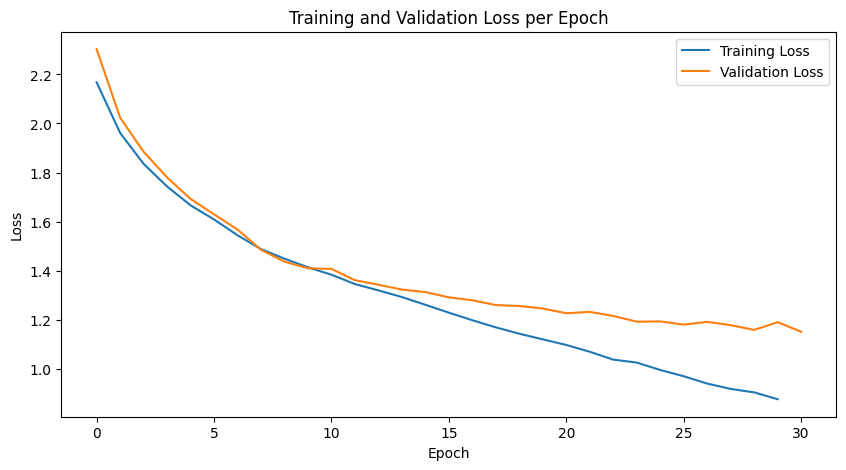

In [33]:
# Transforms
regularization_cnn_train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.ToTensor()
])

regularization_cnn_test_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    transforms.Grayscale()
])

# --- Load Imagenette Dataset ---
train_dataset = Imagenette("data/imagenette/train/", split="train", size="160px", download=True, transform=regularization_cnn_train_transforms)
test_dataset = Imagenette("data/imagenette/test/", split="val", size="160px", download=True, transform=regularization_cnn_test_transforms)

# --- Split into training and validation ---
train_set_size = int(len(train_dataset) * 0.9)
val_set_size = len(train_dataset) - train_set_size

seed = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(train_dataset, [train_set_size, val_set_size], generator=seed)
val_dataset.dataset.transform = basic_cnn_test_transforms

train_loader = DataLoader(train_dataset, batch_size=128, num_workers=8, shuffle=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=8, shuffle=False, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=256, num_workers=8, shuffle=False, persistent_workers=True)

# Model
model = RegularizationCNN(num_classes=10)

# Callbacks
early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=5)
checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

# Trainer
trainer = L.Trainer(
    max_epochs=30,
    callbacks=[early_stop_callback, checkpoint_callback]
)

# Train
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# Test
trainer.test(model=model, dataloaders=test_loader)

# Plot losses
plot_losses(model)

🔹 4. TransferLearningCNN
Architecture Overview:
A CNN designed from scratch to simulate a transfer learning pipeline, particularly for datasets with 3-channel (RGB) images, such as CIFAR-10.

Layers:
- Input Channels: 3 (RGB images)

- Convolutional Layers:

    1. Conv2d(3, 32, kernel_size=3, stride=1, padding=1) → ReLU → MaxPool2d(2,2)

    2. Conv2d(32, 64, kernel_size=3, stride=1, padding=1) → ReLU → MaxPool2d(2,2)

    3. Conv2d(64, 128, kernel_size=3, stride=1, padding=1) → ReLU → MaxPool2d(2,2)

- Flattening: Input becomes 128 * 4 * 4 assuming 32x32 input size.

- Fully Connected Layers:

    - Linear(128 * 4 * 4, 256) → ReLU

    - Linear(256, num_classes)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | conv_layers | Sequential         | 93.2 K | train
1 | fc_layers   | Sequential         | 527 K  | train
2 | accuracy    | MulticlassAccuracy | 0      | train
-----------------------------------------------------------
620 K     Trainable params
0         Non-trainable params
620 K     Total params
2.481     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 352/352 [00:03<00:00, 89.68it/s, v_num=24]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 352/352 [00:04<00:00, 81.72it/s, v_num=24]     

Epoch 0, global step 352: 'val_loss' reached 1.31302 (best 1.31302), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/cifar10_cnn-v1.ckpt' as top 1


Epoch 1: 100%|██████████| 352/352 [00:04<00:00, 74.72it/s, v_num=24]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 352/352 [00:04<00:00, 70.53it/s, v_num=24]     

Epoch 1, global step 704: 'val_loss' reached 1.08514 (best 1.08514), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/cifar10_cnn-v1.ckpt' as top 1


Epoch 2: 100%|██████████| 352/352 [00:04<00:00, 87.29it/s, v_num=24]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 352/352 [00:04<00:00, 81.10it/s, v_num=24]     

Epoch 2, global step 1056: 'val_loss' reached 0.97523 (best 0.97523), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/cifar10_cnn-v1.ckpt' as top 1


Epoch 3: 100%|██████████| 352/352 [00:03<00:00, 102.46it/s, v_num=24]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 352/352 [00:03<00:00, 93.47it/s, v_num=24]     

Epoch 3, global step 1408: 'val_loss' reached 0.91539 (best 0.91539), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/cifar10_cnn-v1.ckpt' as top 1


Epoch 4: 100%|██████████| 352/352 [00:03<00:00, 98.58it/s, v_num=24] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 352/352 [00:03<00:00, 91.74it/s, v_num=24]     

Epoch 4, global step 1760: 'val_loss' reached 0.87686 (best 0.87686), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/cifar10_cnn-v1.ckpt' as top 1


Epoch 5: 100%|██████████| 352/352 [00:03<00:00, 97.06it/s, v_num=24]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 352/352 [00:03<00:00, 89.95it/s, v_num=24]     

Epoch 5, global step 2112: 'val_loss' reached 0.80864 (best 0.80864), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/cifar10_cnn-v1.ckpt' as top 1


Epoch 6: 100%|██████████| 352/352 [00:03<00:00, 100.80it/s, v_num=24]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 352/352 [00:03<00:00, 92.19it/s, v_num=24]     

Epoch 6, global step 2464: 'val_loss' reached 0.76352 (best 0.76352), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/cifar10_cnn-v1.ckpt' as top 1


Epoch 7: 100%|██████████| 352/352 [00:03<00:00, 102.46it/s, v_num=24]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 352/352 [00:03<00:00, 94.19it/s, v_num=24]     

Epoch 7, global step 2816: 'val_loss' reached 0.75250 (best 0.75250), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/cifar10_cnn-v1.ckpt' as top 1


Epoch 8: 100%|██████████| 352/352 [00:03<00:00, 97.69it/s, v_num=24] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 352/352 [00:03<00:00, 89.39it/s, v_num=24]     

Epoch 8, global step 3168: 'val_loss' reached 0.72222 (best 0.72222), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/cifar10_cnn-v1.ckpt' as top 1


Epoch 9: 100%|██████████| 352/352 [00:04<00:00, 72.25it/s, v_num=24]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 352/352 [00:05<00:00, 67.96it/s, v_num=24]     

Epoch 9, global step 3520: 'val_loss' reached 0.69875 (best 0.69875), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/cifar10_cnn-v1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Testing DataLoader 0: 100%|██████████| 79/79 [00:00<00:00, 172.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.7753000259399414
        test_loss            0.64690101146698
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


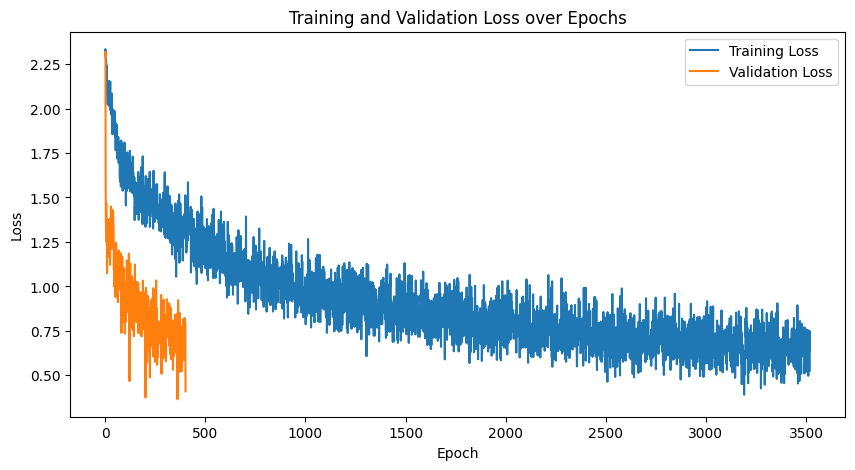

In [34]:
class TransferLearningCNN(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()

        # Convolutional Layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully Connected Layers
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.train_losses.append(loss.item())
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        self.accuracy(y_hat, y)
        self.val_losses.append(loss.item())
        self.log("val_loss", loss)
        self.log("val_accuracy", self.accuracy)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        self.accuracy(y_hat, y)

        self.log("test_loss", loss)
        self.log("test_accuracy", self.accuracy)

    def train_epoch(self):
        avg_train_loss = sum(self.train_losses) / len(self.train_losses) if self.train_losses else None
        print(f'Epoch {self.current_epoch}: Average Training Loss:{avg_train_loss}')

    def validation_epoch(self):
        avg_val_loss = sum(self.val_losses) / len(self.val_losses) if self.val_losses else None
        print(f'Epoch {self.current_epoch}: Average Validation Loss:{avg_val_loss}')

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = CIFAR10(root="data", train=True, download=True, transform=train_transforms)
test_dataset = CIFAR10(root="data", train=False, download=True, transform=test_transforms)

train_set_size = int(len(train_dataset) * 0.9)
val_set_size = len(train_dataset) - train_set_size

seed = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(train_dataset, [train_set_size, val_set_size], generator=seed)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8, persistent_workers=True)

model = TransferLearningCNN(num_classes=10)

early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=5)
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    dirpath="./checkpoints",
    filename="cifar10_cnn",
    save_top_k=1,
    verbose=True
)

trainer = L.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=1,
    callbacks=[early_stop_callback, checkpoint_callback],
    enable_progress_bar=True
)

trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

trainer.test(model=model, dataloaders=test_loader)

def plot_transfer_losses(model):
    plt.figure(figsize=(10, 5))
    plt.plot(model.train_losses, label="Training Loss")
    plt.plot(model.val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.show()

plot_transfer_losses(model)

Loading Saved Model

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | conv_layers | Sequential         | 93.2 K | train
1 | fc_layers   | Sequential         | 527 K  | train
2 | accuracy    | MulticlassAccuracy | 0      | train
-----------------------------------------------------------
527 K     Trainable params
93.2 K    Non-trainable params
620 K     Total params
2.481     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 352/352 [00:02<00:00, 132.38it/s, v_num=27]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 352/352 [00:02<00:00, 120.97it/s, v_num=27]    

Epoch 0, global step 352: 'val_loss' reached 0.63568 (best 0.63568), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/cifar10_finetuned-v2.ckpt' as top 1


Epoch 1: 100%|██████████| 352/352 [00:02<00:00, 144.79it/s, v_num=27]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 352/352 [00:02<00:00, 130.82it/s, v_num=27]    

Epoch 1, global step 704: 'val_loss' was not in top 1


Epoch 2: 100%|██████████| 352/352 [00:02<00:00, 153.43it/s, v_num=27]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 352/352 [00:02<00:00, 138.00it/s, v_num=27]    

Epoch 2, global step 1056: 'val_loss' reached 0.62713 (best 0.62713), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/cifar10_finetuned-v2.ckpt' as top 1


Epoch 3: 100%|██████████| 352/352 [00:02<00:00, 156.91it/s, v_num=27]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 352/352 [00:02<00:00, 141.32it/s, v_num=27]    

Epoch 3, global step 1408: 'val_loss' was not in top 1


Epoch 4: 100%|██████████| 352/352 [00:02<00:00, 165.44it/s, v_num=27]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 352/352 [00:02<00:00, 148.67it/s, v_num=27]    

Epoch 4, global step 1760: 'val_loss' was not in top 1


Epoch 5: 100%|██████████| 352/352 [00:02<00:00, 162.77it/s, v_num=27]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 352/352 [00:02<00:00, 145.59it/s, v_num=27]    

Epoch 5, global step 2112: 'val_loss' reached 0.61186 (best 0.61186), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/cifar10_finetuned-v2.ckpt' as top 1


Epoch 6: 100%|██████████| 352/352 [00:02<00:00, 129.34it/s, v_num=27]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 352/352 [00:02<00:00, 117.69it/s, v_num=27]    

Epoch 6, global step 2464: 'val_loss' was not in top 1


Epoch 7: 100%|██████████| 352/352 [00:02<00:00, 150.30it/s, v_num=27]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 352/352 [00:02<00:00, 135.09it/s, v_num=27]    

Epoch 7, global step 2816: 'val_loss' reached 0.60999 (best 0.60999), saving model to '/Users/ashwin/Documents/workspace/DataSpellProjects/CSE-6363/CSE6363/assignments/ml_assignment_4_sol/checkpoints/cifar10_finetuned-v2.ckpt' as top 1


Epoch 8: 100%|██████████| 352/352 [00:02<00:00, 134.54it/s, v_num=27]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 352/352 [00:02<00:00, 122.51it/s, v_num=27]    

Epoch 8, global step 3168: 'val_loss' was not in top 1


Epoch 9: 100%|██████████| 352/352 [00:02<00:00, 170.90it/s, v_num=27]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 352/352 [00:02<00:00, 153.46it/s, v_num=27]    

Epoch 9, global step 3520: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Testing DataLoader 0: 100%|██████████| 79/79 [00:00<00:00, 285.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8022000193595886
        test_loss           0.5936298370361328
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


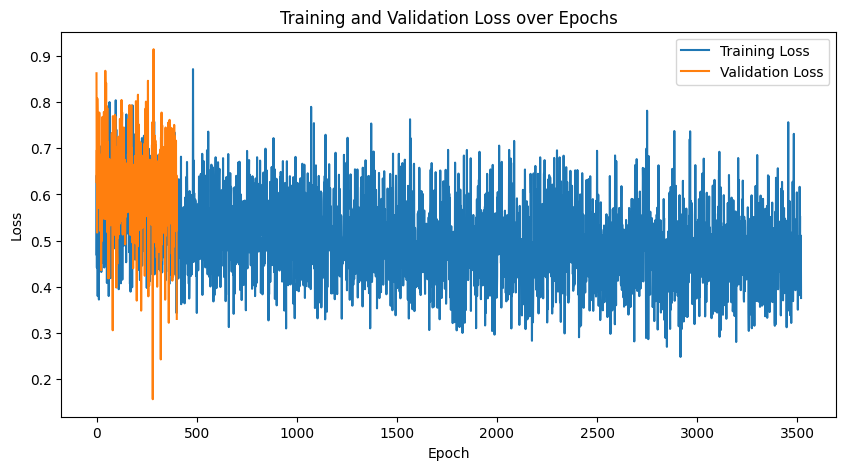

In [39]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = CIFAR10(root="data", train=True, download=True, transform=train_transforms)
test_dataset = CIFAR10(root="data", train=False, download=True, transform=test_transforms)

train_set_size = int(len(train_dataset) * 0.9)
val_set_size = len(train_dataset) - train_set_size

seed = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(train_dataset, [train_set_size, val_set_size], generator=seed)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8, persistent_workers=True)

loaded_model = TransferLearningCNN(num_classes=10)
checkpoint = torch.load("./checkpoints/cifar10_cnn.ckpt")
loaded_model.load_state_dict(checkpoint["state_dict"])

for param in loaded_model.conv_layers.parameters():
    param.requires_grad = False  # Freeze convolutional layers

early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=5)
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    dirpath="./checkpoints",
    filename="cifar10_finetuned",
    save_top_k=1,
    verbose=True
)

# Trainer setup
trainer = L.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=1,
    callbacks=[early_stop_callback, checkpoint_callback]
)

trainer.fit(model=loaded_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

trainer.test(model=loaded_model, dataloaders=test_loader)

plot_transfer_losses(loaded_model)